In [1]:
from lmfit import minimize, Parameters

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt

# import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
# from emll.aesara_utils import LeastSquaresSolve

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import the data 
df = pd.read_csv('data/threestep_1.05.csv')

In [3]:
r = te.loada('models/threestep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

## Setting up linlog variables
Dimensions for the following:

*e and v must be same length*

- `ex` is (#rxn, #intmet) aka (n,m)
- `ey` is (#rxn, #extmet) aka (n,p)

- `en` is 
- `xn` is (#intmet, #rxn) aka (m,n)
- `yn` is (#extmet, #rxn) aka (p,n)
- `vn` is 

In [6]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [7]:
en = df[enzymes].loc[1:len(internal)+1]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(internal)+1]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


## Best case scenarios for linlog. 
Here, I calculate the linlog equation with groundtruth values calculated through
tellurium, subtract them from the ground truth flux values, and calculate the 
chi squared value.

I compare whether to scalar or matrix multiply the first factor of the equation 
(`outer`). 

In [8]:
# scalar multiplication
gt_fluxes = df[fluxes].loc[1:3].values
inner = np.ones((3,3)) + (ex@np.log(xn).T).values + (ey@np.log(yn).T).values
outer = (en.values*v_star.values) # (.05 * np.diag(v_star)) + (v_star[0]*np.ones((2,2)))
print(outer)

linlog_fluxes = (outer * inner).T
res = linlog_fluxes - gt_fluxes
(res*res).sum()

[[2.12700036 2.02571462 2.02571462]
 [2.02571462 2.12700036 2.02571462]
 [2.02571462 2.02571462 2.12700036]]


4.0738937714862057e-07

The chi squared value for the matrix multiplication is higher, so perhaps this 
suggests that the scalar multiplication method is more accurate. 

## Using lmfit to predict elasticity values w/o ey values

In [9]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, v_star, df, *args, **kws):
    
    ex = np.zeros((3,2))
    ex[0,0] = params['Ex0']
    ex[1,0] = params['Ex1']
    ex[1,1] = params['Ex2']
    ex[2,1] = params['Ex3']

    a = (en.values*v_star.values)
    bb = np.ones((3,3))
    cc = ex@(np.log(xn)).T

    model = a*(bb + cc)

    return (df[fluxes].loc[1:len(internal)+1].values-model.T).values

params = Parameters()

for i in range(4):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
out.params

2.0062857505690048e-07


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-1.14621560,0.00253548,(0.22%),0,-10.0000000,10.0000000,True
Ex1,0.78136787,0.00274349,(0.35%),0,-10.0000000,10.0000000,True
Ex2,-0.68334286,0.00210679,(0.31%),0,-10.0000000,10.0000000,True
Ex3,0.80899888,0.00195064,(0.24%),0,-10.0000000,10.0000000,True


In [10]:
ex

            S1,        S2
J1 [[ -1.14426,         0],
J2  [ 0.785625, -0.687276],
J3  [        0,  0.809538]]

Perfect results!

Here is the ratio of the elasticity values:

In [11]:
ratio1 = out.params['Ex0'] / out.params['Ex1']
print(ratio1)

-1.46693463627834


In [14]:
ratio2 = out.params['Ex1'] / out.params['Ex2']
ratio2

-1.143449242115589

In [15]:
ratio3 = out.params['Ex2'] / out.params['Ex3']
ratio3

-0.8446771391845432

In [16]:
ratio4 = out.params['Ex3'] / out.params['Ex1']
ratio4

1.0353623510992218

Let's compute some control coefficients.

*from [Draft:Catalog of MCA Control Patterns](https://en.wikipedia.org/wiki/Draft:Catalog_of_MCA_Control_Patterns)*

In [18]:
E11= out.params['Ex0']
E12= 0 
E21= out.params['Ex1']
E22= out.params['Ex2']
E31= 0 
E32= out.params['Ex3']

d = E21*E32 - E11*E32 + E11*E22

In [19]:
CJe1 = round(E21*E32/d, 5)
CJe2 = round(-E11*E32/d, 5)
CJe3 = round(E11*E22/d, 5)

print(CJe1, CJe2, CJe3)

0.26983 0.39582 0.33434


In [21]:
r.getScaledFluxControlCoefficientMatrix()

            J1,       J2,       J3
J1 [[ 0.270781, 0.394391, 0.334828],
J2  [ 0.270781, 0.394391, 0.334828],
J3  [ 0.270781, 0.394391, 0.334828]]

## Let's try to compute all the elasticities, even the ones that are zero


In [22]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex = np.zeros((3,2))
    ex[0,0] = params['Ex0']
    ex[0,1] = params['Ex1']
    ex[1,0] = params['Ex2']
    ex[1,1] = params['Ex3']
    ex[2,0] = params['Ex4']
    ex[2,1] = params['Ex5']

    a = (en.values*v_star.values)
    bb = np.ones((3,3))
    cc = ex@(np.log(xn)).T

    model = a*(bb + cc)

    return (df[fluxes].loc[1:len(internal)+1].values-model.T).values

params = Parameters()

for i in range(6):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
out.params

1.9983949121246353e-07


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-1.14609789,0.00351427,(0.31%),0,-10.0000000,10.0000000,True
Ex1,-2.5245e-04,0.00277801,(1100.42%),0,-10.0000000,10.0000000,True
Ex2,0.78136787,0.00353486,(0.45%),0,-10.0000000,10.0000000,True
Ex3,-0.68334286,0.00271450,(0.40%),0,-10.0000000,10.0000000,True
Ex4,-2.1622e-04,0.00360997,(1669.56%),0,-10.0000000,10.0000000,True
Ex5,0.80905916,0.00270734,(0.33%),0,-10.0000000,10.0000000,True


In [23]:
E11= out.params['Ex0']
E12= out.params['Ex1'] 
E21= out.params['Ex2']
E22= out.params['Ex3']
E31= out.params['Ex4']
E32= out.params['Ex5']

d = E21*E32 - E11*E32 + E11*E22

In [24]:
CJe1 = round(E21*E32/d, 5)
CJe2 = round(-E11*E32/d, 5)
CJe3 = round(E11*E22/d, 5)

print(CJe1, CJe2, CJe3)

0.26986 0.39582 0.33432


In [25]:
r.getScaledFluxControlCoefficientMatrix()

            J1,       J2,       J3
J1 [[ 0.270781, 0.394391, 0.334828],
J2  [ 0.270781, 0.394391, 0.334828],
J3  [ 0.270781, 0.394391, 0.334828]]

Not bad results!

## Using a higher perturbation dataset

In [26]:
# import the data 
df = pd.read_csv('data/threestep_1.5.csv')

r = te.loada('models/threestep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

In [27]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(internal)+1]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]
yn = df[external].iloc[-(len(external)):]/df[external].loc[0]
vn = df[fluxes].loc[1:len(internal)+1]/df[fluxes].loc[0]

In [28]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex = np.zeros((3,2))
    ex[0,0] = params['Ex0']
    ex[0,1] = params['Ex1']
    ex[1,0] = params['Ex2']
    ex[1,1] = params['Ex3']
    ex[2,0] = params['Ex4']
    ex[2,1] = params['Ex5']

    a = (en.values*v_star.values)
    bb = np.ones((3,3))
    cc = ex@(np.log(xn)).T

    model = a*(bb + cc)

    return (df[fluxes].loc[1:len(internal)+1].values-model.T).values

params = Parameters()

for i in range(6):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
out.params

0.0009002741677515823


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-1.15806940,0.02451794,(2.12%),0,-10.0000000,10.0000000,True
Ex1,-0.00345407,0.02310836,(669.02%),0,-10.0000000,10.0000000,True
Ex2,0.73563561,0.02577300,(3.50%),0,-10.0000000,10.0000000,True
Ex3,-0.64415892,0.01916529,(2.98%),0,-10.0000000,10.0000000,True
Ex4,-0.00304233,0.03063217,(1006.87%),0,-10.0000000,10.0000000,True
Ex5,0.79996406,0.01861238,(2.33%),0,-10.0000000,10.0000000,True


In [31]:
print("ground truth ex ratio: ", ratio1)
ratio = out.params['Ex0'].value / out.params['Ex2'].value
print("lmfit value ratio:", ratio)
# print("lmfit value ratio reciprocal:", 1/ratio)

ground truth ex ratio:  -1.46693463627834
lmfit value ratio: -1.5742432593370312


Let's compare how the FCC predictions change with the change in perturbation levels. 

In [38]:
# import the data 
def calculate_ratios(pt_lvl):
    df = pd.read_csv(f'data/threestep_{pt_lvl}.csv')

    r = te.loada('models/threestep.ant')
    r.steadyState()
    
    internal = r.getFloatingSpeciesIds()
    fluxes = ['v_' + i for i in r.getReactionIds()]

    v_star = df[fluxes].loc[0]
    xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]

    params = Parameters()

    for i in range(6):
        params.add('Ex'+str(i), value=0, min=-10, max=10)

    out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

    E11= out.params['Ex0']
    E12= out.params['Ex1'] 
    E21= out.params['Ex2']
    E22= out.params['Ex3']
    E31= out.params['Ex4']
    E32= out.params['Ex5']

    d = E21*E32 - E11*E32 + E11*E22

    CJe1 = round(E21*E32/d, 5)
    CJe2 = round(-E11*E32/d, 5)
    CJe3 = round(E11*E22/d, 5)

    return [CJe1, CJe2, CJe3]

In [39]:
pt_levels = list(np.arange(0.1, 2, 0.1).round(2))

FCCs = []

for lvl in pt_levels: 
    FCCs.append(calculate_ratios(lvl))

FCC_arr = np.array(FCCs)

C:\Users\user\AppData\Local\Temp\ipykernel_16428\1962108612.py:30: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\user\AppData\Local\Temp\ipykernel_16428\1962108612.py:31: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\user\AppData\Local\Temp\ipykernel_16428\1962108612.py:32: RuntimeWarning:

invalid value encountered in scalar divide



Text(0.5, 0.98, 'FCCs predicted by lmfit as perturbation strength varies\n')

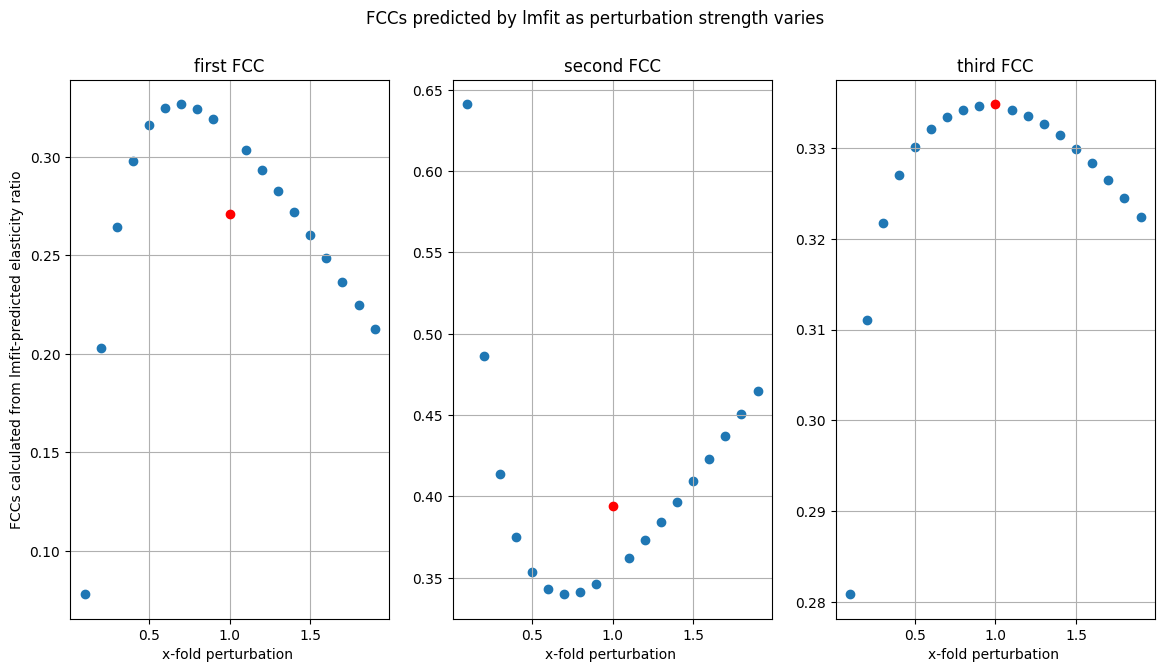

In [60]:
plt.figure(figsize=(14,7))

plt.subplot(1, 3, 1)
plt.scatter(pt_levels, FCC_arr[:,0])
plt.grid()
plt.title('first FCC')
plt.xlabel('x-fold perturbation ')
plt.ylabel('FCCs calculated from lmfit-predicted elasticity ratio')
plt.plot(1, r.getScaledFluxControlCoefficientMatrix()[0,0],'ro') 

plt.subplot(1, 3, 2)
plt.scatter(pt_levels, FCC_arr[:,1])
plt.grid()
plt.title('second FCC')
plt.xlabel('x-fold perturbation ')
plt.plot(1, r.getScaledFluxControlCoefficientMatrix()[0,1],'ro') 

plt.subplot(1, 3, 3)
plt.scatter(pt_levels, FCC_arr[:,2])
plt.grid()
plt.title('third FCC')
plt.xlabel('x-fold perturbation ')
plt.plot(1, r.getScaledFluxControlCoefficientMatrix()[0,2],'ro') 

plt.suptitle("FCCs predicted by lmfit as perturbation strength varies\n")

In [62]:
r.getScaledFluxControlCoefficientMatrix()

            J1,       J2,       J3
J1 [[ 0.270781, 0.394391, 0.334828],
J2  [ 0.270781, 0.394391, 0.334828],
J3  [ 0.270781, 0.394391, 0.334828]]